In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import glob
import re
from matplotlib import colors
import sys
from WCTE_event_display.EventDisplay import EventDisplay
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import os
import json

eventDisplay = EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

In [4]:
# run specific setup
runNumber = 1994
config_file = "TriggerConfig/configurations/lep9li_v20_config.json"
t4_qcut = 300
hc0_cut = 150
hc1_cut = 100
act1_ev = 900
act2_pi = 1800
act2_mu_low = 2000
act2_mu_high = 10000

# load VME matched file
file_pattern = "/eos/experiment/wcte/data/2025_commissioning/offline_data_vme_match/WCTE_offline_R"+str(runNumber)+"S0.root"
file_list = glob.glob(file_pattern)

def extract_p_number(file_name):
    match = re.search(r'P(\d+)\.root$', file_name)  # Extract number after 'P'
    return int(match.group(1)) if match else float('inf')  # Convert to int, default high if no match

file_list = sorted(file_list, key=extract_p_number)
# print(file_list)

all_events_list = []
# Loop over files and load data
for ifile, file_path in enumerate(file_list):
    if ifile>9:
        break
    print(f"Loading: {file_path}")
    
    with uproot.open(file_path) as root_file:
        tree = root_file["WCTEReadoutWindows"]
        events = tree.arrays(['beamline_pmt_qdc_charges',
                              'beamline_pmt_qdc_ids',
                              'beamline_pmt_tdc_times',
                              'beamline_pmt_tdc_ids',
                              'hit_pmt_charges',
                              'hit_pmt_times',
                              'hit_mpmt_slot_ids',
                              'hit_pmt_position_ids',
                              'hit_mpmt_card_ids'],library="ak", # entry_start=0, entry_stop=100000 # to limit events loaded
                              )  # Load branches as awkward arrays
        all_events_list.append(events)  # Store in list

# Concatenate everything into a single awkward array
if all_events_list:
    all_events = ak.concatenate(all_events_list,axis=0)

print(f"Total events loaded: {len(all_events)}")

Loading: /eos/experiment/wcte/data/2025_commissioning/offline_data_vme_match/WCTE_offline_R1994S0.root


Total events loaded: 562348


In [5]:
# preparation for VME analysis
with open(config_file) as json_data:
    trig_config = json.load(json_data)
input_signals = trig_config['input_signals']

id_to_short_name = {}
short_name_to_id = {}

for ch, info in input_signals.items():
    short_name = info['short_name']
    id_to_short_name[int(ch)] = short_name
    short_name_to_id[short_name] = int(ch)

act1_id = [short_name_to_id['ACT0-L'],short_name_to_id['ACT0-R'],short_name_to_id['ACT1-L'],short_name_to_id['ACT1-R'],short_name_to_id['ACT2-L'],short_name_to_id['ACT2-R']]
act2_id = [short_name_to_id['ACT3-L'],short_name_to_id['ACT3-R'],short_name_to_id['ACT4-L'],short_name_to_id['ACT4-R'],short_name_to_id['ACT5-L'],short_name_to_id['ACT5-R']]
act2_right_id = [short_name_to_id['ACT3-R'],short_name_to_id['ACT4-R'],short_name_to_id['ACT5-R']]
act2_left_id = [short_name_to_id['ACT3-L'],short_name_to_id['ACT4-L'],short_name_to_id['ACT5-L']]
t0_id = [short_name_to_id['T0-0L'],short_name_to_id['T0-1L'],short_name_to_id['T0-0R'],short_name_to_id['T0-1R']]
t1_id = [short_name_to_id['T1-0L'],short_name_to_id['T1-1L'],short_name_to_id['T1-0R'],short_name_to_id['T1-1R']]
t4L_id = short_name_to_id['T4-L']
t4R_id = short_name_to_id['T4-R']
hc0_id = short_name_to_id['HC-0']
hc1_id = short_name_to_id['HC-1']
slabR_id = [short_name_to_id['TOF-0'],short_name_to_id['TOF-1'],short_name_to_id['TOF-2'],short_name_to_id['TOF-3'],short_name_to_id['TOF-4'],short_name_to_id['TOF-5'],short_name_to_id['TOF-6'],short_name_to_id['TOF-7']]
slabL_id = [short_name_to_id['TOF-8'],short_name_to_id['TOF-9'],short_name_to_id['TOF-A'],short_name_to_id['TOF-B'],short_name_to_id['TOF-C'],short_name_to_id['TOF-D'],short_name_to_id['TOF-E'],short_name_to_id['TOF-F']]

def fill_pmt(npmt,values,ids,fill_value):
    n_events = len(values)
    # Flatten event-wise data
    flat_ids = ak.flatten(ids)
    flat_charges = ak.flatten(values)
    event_offsets = ak.broadcast_arrays(ak.local_index(ids, axis=0), ids)[0]
    flat_event_ids = ak.flatten(event_offsets)

    # Create a mask to keep only the first occurrence of each (event, pmt_id)
    # by creating a structured array and using np.unique
    combined = np._core.records.fromarrays([flat_event_ids, flat_ids], names='event,pmt')
    _, unique_indices = np.unique(combined, return_index=True)
    
    # Select only unique (event, pmt) entries
    flat_event_ids = flat_event_ids[unique_indices]
    flat_ids = flat_ids[unique_indices]
    flat_charges = flat_charges[unique_indices]

    # Create a dense (n_events x npmt) array
    q = np.full((n_events, npmt),fill_value,dtype=float)
    q[flat_event_ids, flat_ids] = flat_charges

    # Convert back to Awkward Array if needed
    return ak.Array(q)

qdc_charges = all_events['beamline_pmt_qdc_charges']
qdc_ids = all_events['beamline_pmt_qdc_ids']
tdc_times = all_events['beamline_pmt_tdc_times']
tdc_ids = all_events['beamline_pmt_tdc_ids']

npmt = 64
q = fill_pmt(npmt,qdc_charges,qdc_ids,0)
tdc = fill_pmt(npmt,tdc_times,tdc_ids,-9999)

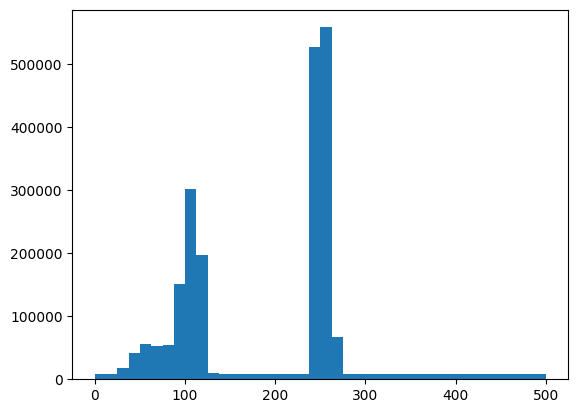

In [6]:
# check tdc range
_,_,_ = plt.hist(np.concatenate(tdc),bins=40,range=[0,500])

In [6]:
# vme tdc cut decided from histogram above
tdc_cut = 200

In [7]:
# check mPMT raw hit distribution
pmt_q = all_events['hit_pmt_charges']
pmt_t = all_events['hit_pmt_times']
hit_mpmt_slot_ids = all_events['hit_mpmt_slot_ids']
hit_pmt_position_ids = all_events['hit_pmt_position_ids']
hit_mpmt_card_ids = all_events['hit_mpmt_card_ids']

pmt_q = pmt_q[hit_mpmt_card_ids<120]
pmt_t = pmt_t[hit_mpmt_card_ids<120]
pmt_id = ((hit_mpmt_slot_ids*19)+hit_pmt_position_ids)[hit_mpmt_card_ids<120]

In [9]:
np.min(pmt_t)

np.float64(8.0)

In [10]:
np.max(pmt_t)

np.float64(102399.99719238281)

Text(0, 0.5, 'Count')

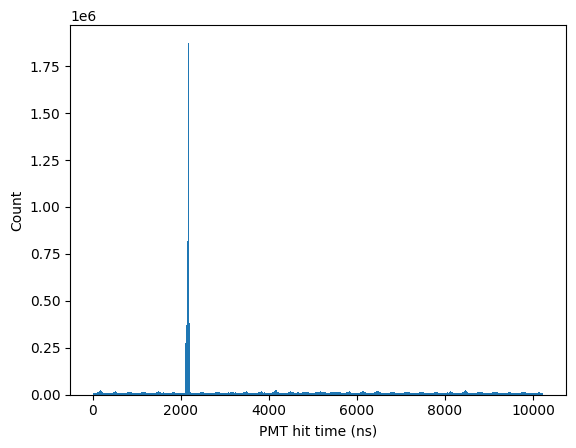

In [13]:
# time distribution
plt.hist(np.concatenate(pmt_t),bins=1000,range=[0,10240])
plt.xlabel('PMT hit time (ns)')
plt.ylabel('Count')

[INFO] Total events: 562348
[INFO] Computing activity sums and TOF values...


[INFO] Applying additional cuts...
[INFO] Defining cut sequences...
[INFO] Converting to NumPy for stats...
[INFO] Gathering statistics per cut set...
[INFO] Configuring plots (1D & 2D)...
[INFO] Generating histograms and saving plots...
[INFO] Saved plot: fig/h_run1994_t0t1_raw.png
[INFO] Saved plot: fig/h_run1994_t0t1_common.png
[INFO] Saved plot: fig/h_run1994_t0t1_ev.png
[INFO] Saved plot: fig/h_run1994_t0t1_ele.png
[INFO] Saved plot: fig/h_run1994_t0t1_pi.png
[INFO] Saved plot: fig/h_run1994_t0t1_mu.png
[INFO] Saved plot: fig/h_run1994_act1_raw.png
[INFO] Saved plot: fig/h_run1994_act1_ev.png
[INFO] Saved plot: fig/h_run1994_act2_raw.png
[INFO] Saved plot: fig/h_run1994_act2_ev.png
[INFO] Saved plot: fig/h_run1994_act1_vs_act2_raw.png
[INFO] Saved plot: fig/h_run1994_act1_vs_act2_common.png
[INFO] Saved plot: fig/h_run1994_act2l_vs_act2r_raw.png
[INFO] Saved plot: fig/h_run1994_act2l_vs_act2r_ev.png
[INFO] Saved plot: fig/h_run1994_act2l_vs_act2r_test.png
[INFO] Saved plot: fig/h_

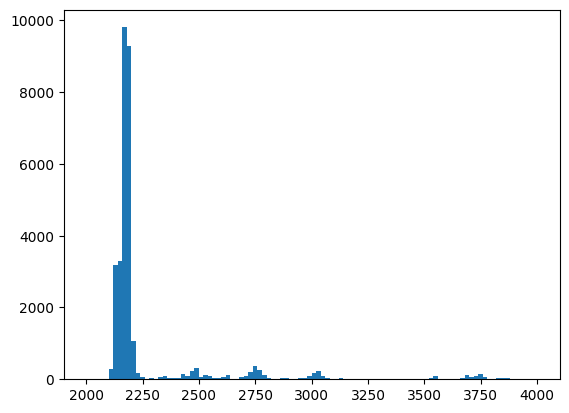

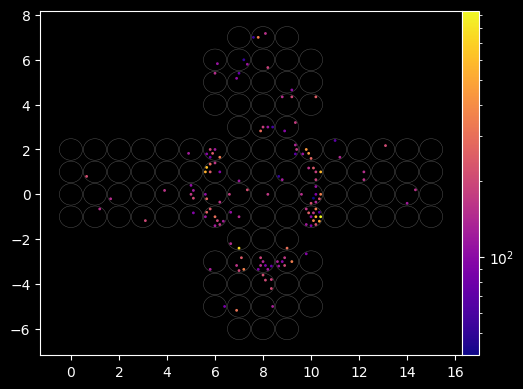

(2014,)


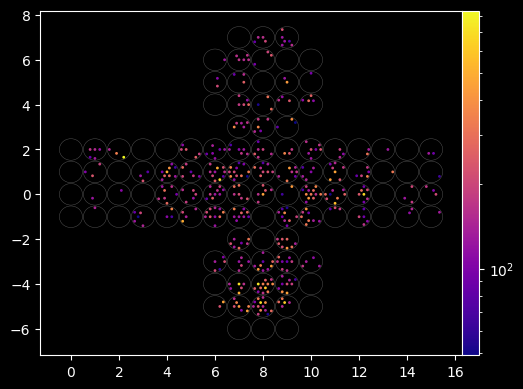

(2014,)


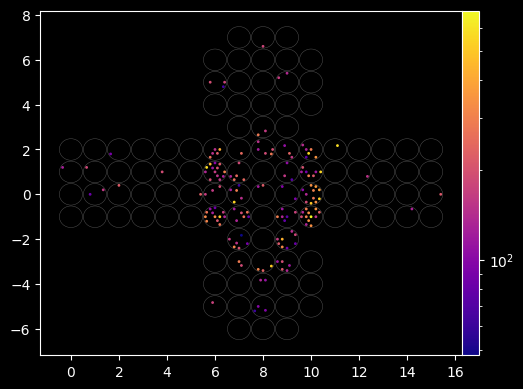

(2014,)


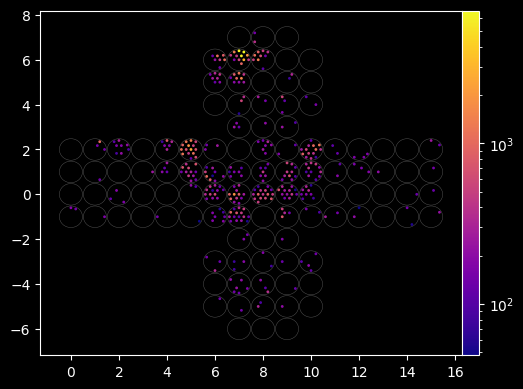

(2014,)


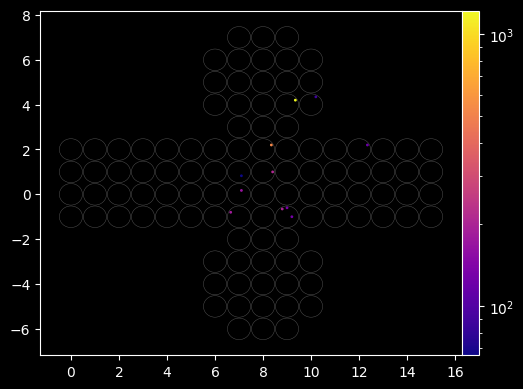

(2014,)


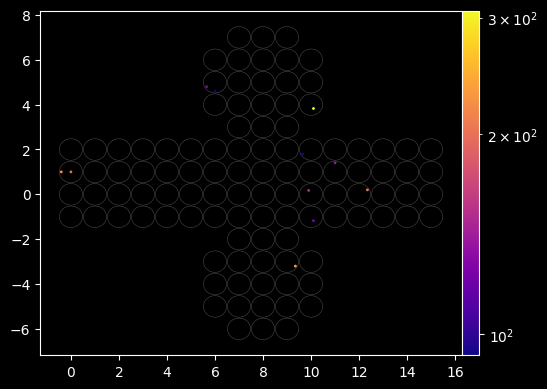

(2014,)


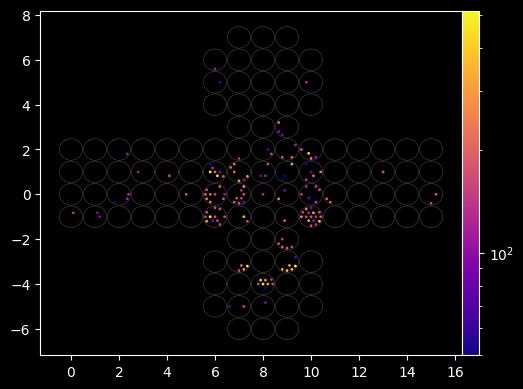

(2014,)


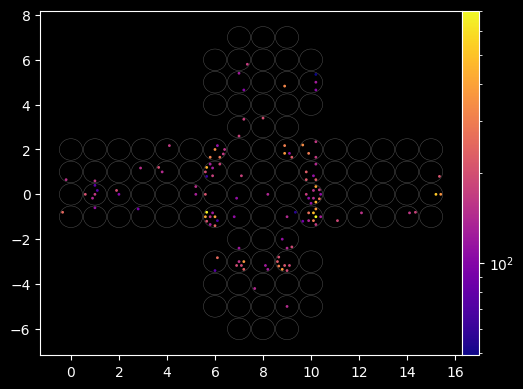

(2014,)


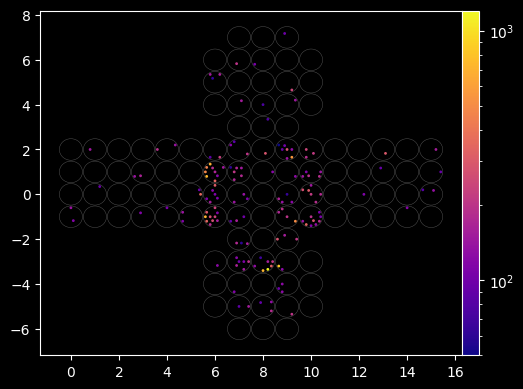

(2014,)


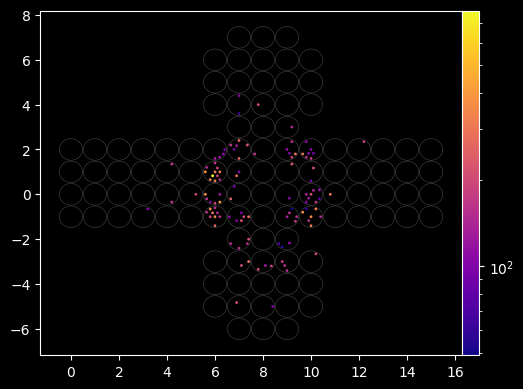

Averaged event display for  pion-only
(2014,)


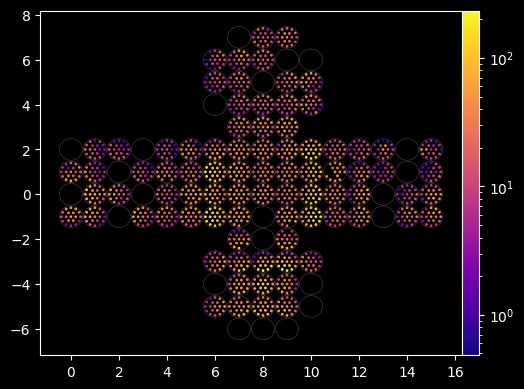

Event display for  muon-only
mPMT time distribution for  muon-only
(2014,)


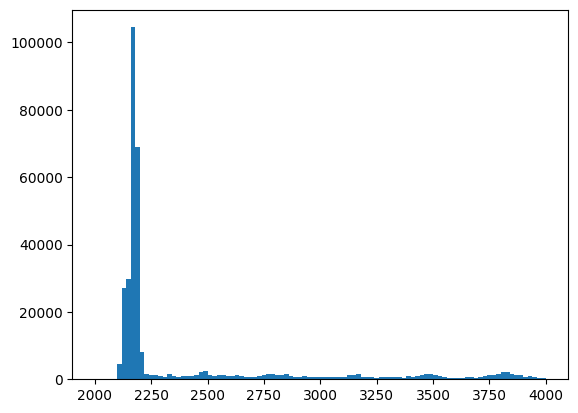

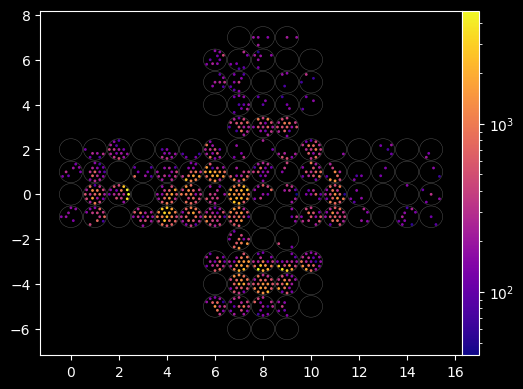

(2014,)


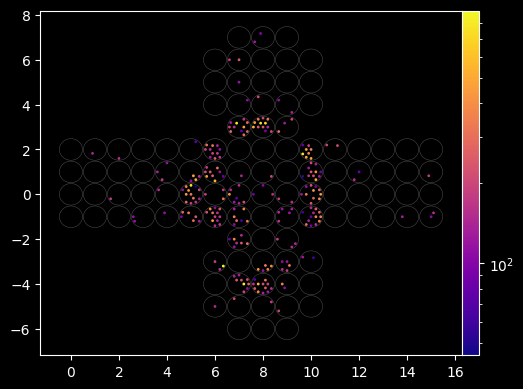

(2014,)


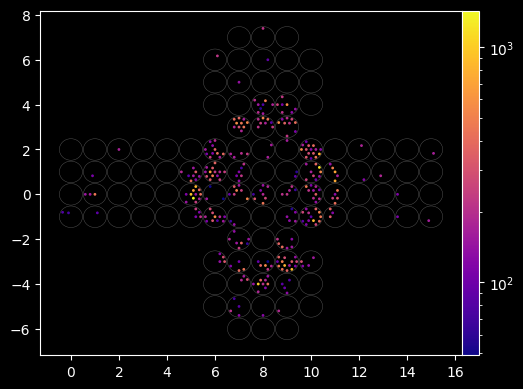

(2014,)


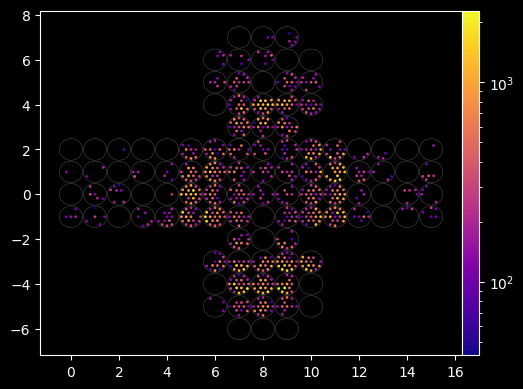

(2014,)


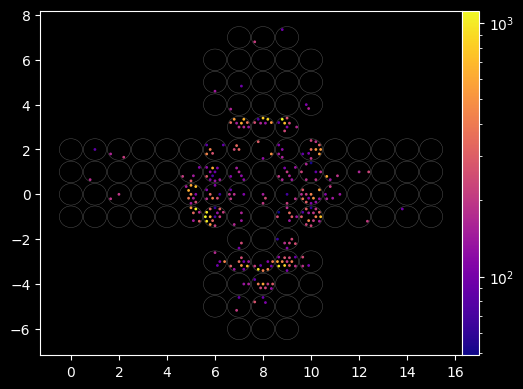

(2014,)


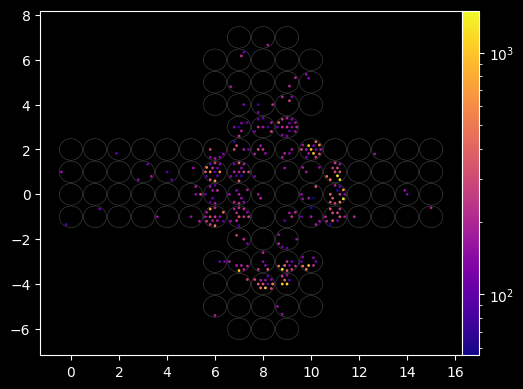

(2014,)


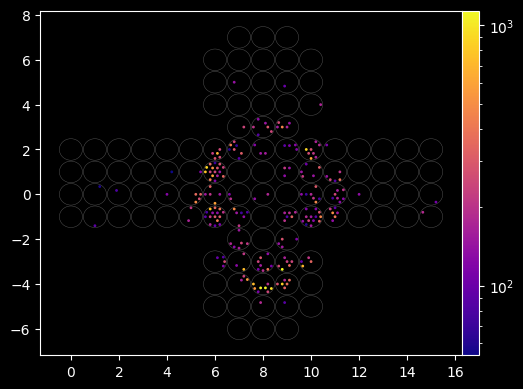

(2014,)


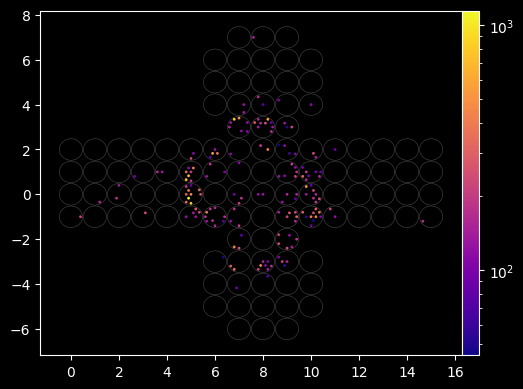

(2014,)


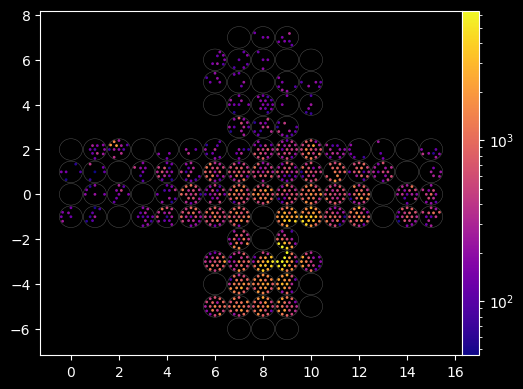

(2014,)


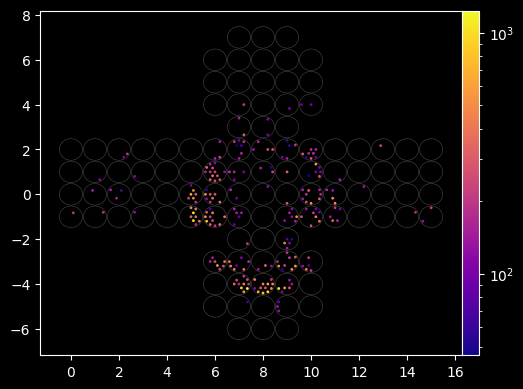

(2014,)


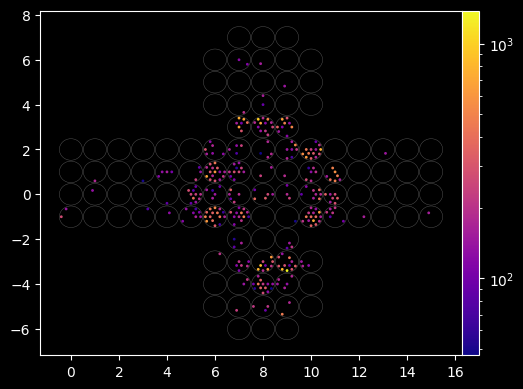

Averaged event display for  muon-only
(2014,)


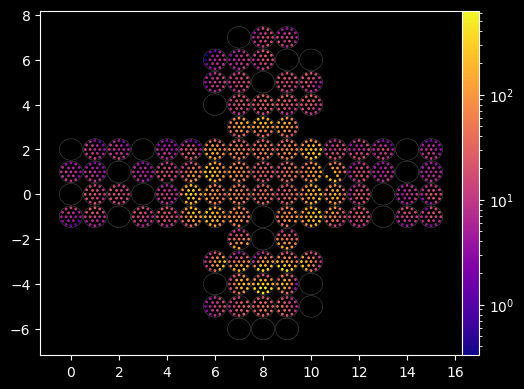

In [8]:
# perform VME analysis similar to shift pc

def vme_analysis(q, tdc):

    total_events = len(q)
    print(f"[INFO] Total events: {total_events}")

    # Compute sums and TOF
    print("[INFO] Computing activity sums and TOF values...")
    act1 = ak.sum(q[:, act1_id], axis=1)
    act2 = ak.sum(q[:, act2_id], axis=1)
    act2_right = ak.sum(q[:, act2_right_id], axis=1)
    act2_left = ak.sum(q[:, act2_left_id], axis=1)
    t0_list = ak.Array(ak.where(tdc[:, t0_id] > -9999, tdc[:, t0_id], 0).to_numpy().T)
    t1_list = ak.Array(ak.where(tdc[:, t1_id] > -9999, tdc[:, t1_id], 0).to_numpy().T)
    hit_t0 = ak.all(tdc[:, t0_id] > -9999, axis=1)
    hit_t1 = ak.all(tdc[:, t1_id] > -9999, axis=1)
    time_t0 = ak.all(t0_list < tdc_cut, axis=0) # cut to only use first tdc peak
    time_t1 = ak.all(t1_list < tdc_cut, axis=0)
    t0_avg = sum(t0_list) / len(t0_id)
    t1_avg = sum(t1_list) / len(t1_id)
    tof = t1_avg - t0_avg

    # Additional cuts
    print("[INFO] Applying additional cuts...")
    mask_t0 = time_t0 & hit_t0
    mask_t1 = time_t1 & hit_t1
    mask_T4 = (
        (tdc[:, t4L_id] > -9999) & (tdc[:, t4R_id] > -9999)
        & (q[:, t4L_id] > t4_qcut) & (q[:, t4R_id] > t4_qcut)
    )
    mask_HC0_1 = ~((q[:, hc0_id] > hc0_cut) | (q[:, hc1_id] > hc1_cut))

    mask_TOF = ak.any((tdc[:, slabR_id] > -9999) & (tdc[:, slabL_id] > -9999), axis=1)

    act_x_point = 2000.0
    act_y_point = 2500.0
    slope     = -act_y_point / act_x_point    
    intercept = act_y_point
    mask_act_lr = act2_right >= (slope * act2_left + intercept)

    # Define cuts
    print("[INFO] Defining cut sequences...")
    cuts = {
        'raw': [('T0', mask_t0), ('T1', mask_t1)],
        'test': [('T0', mask_t0), ('T1', mask_t1), (f'act1<{act1_ev}', act1 < act1_ev), ('T4', mask_T4), ('HC0_1', mask_HC0_1), ('TOF', mask_TOF), ('ACTLine', mask_act_lr)],
        'common': [ ('T0', mask_t0), ('T1', mask_t1), ('T4', mask_T4), ('HC0_1', mask_HC0_1), ('TOF', mask_TOF) ],
        'e-veto': [ ('T0', mask_t0), ('T1', mask_t1), (f'act1<{act1_ev}', act1 < act1_ev), ('T4', mask_T4), ('HC0_1', mask_HC0_1), ('TOF', mask_TOF) ],
        'e-only': [ ('T0', mask_t0), ('T1', mask_t1), (f'act1>{act1_ev}', act1 > act1_ev), ('T4', mask_T4), ('HC0_1', mask_HC0_1), ('TOF', mask_TOF) ],
        'pion-only': [ ('T0', mask_t0), ('T1', mask_t1), (f'act2<{act2_pi}', act2 < act2_pi), (f'act1<{act1_ev}', act1 < act1_ev), ('T4', mask_T4), ('HC0_1', mask_HC0_1), ('TOF', mask_TOF)],
        'muon-only': [ ('T0', mask_t0), ('T1', mask_t1), (f'act2_{act2_mu_low}_{act2_mu_high}', (act2 >= act2_mu_low) & (act2 < act2_mu_high)), (f'act1<{act1_ev}', act1 < act1_ev), ('T4', mask_T4), ('HC0_1', mask_HC0_1), ('TOF', mask_TOF)],
    }

    # Convert to numpy
    print("[INFO] Converting to NumPy for stats...")
    tof_np = ak.to_numpy(tof)
    act1_np = ak.to_numpy(act1)
    act2_np = ak.to_numpy(act2)
    act2_right_np = ak.to_numpy(act2_right)
    act2_left_np = ak.to_numpy(act2_left)

    # Stats
    print("[INFO] Gathering statistics per cut set...")
    stats_data = {}
    for name, seq in cuts.items():
        prev_mask = np.ones(total_events, dtype=bool)
        fail_counts = []
        for _, mask in seq:
            m_np = ak.to_numpy(mask)
            fail_counts.append(int(np.sum(prev_mask & ~m_np)))
            prev_mask &= m_np
        stats_data[name] = {
            'total': total_events,
            'passed': int(np.sum(prev_mask)),
            'fail_counts': fail_counts,
            'mask': prev_mask,
        }

    # Plots
    print("[INFO] Configuring plots (1D & 2D)...")
    plots = [
        {"cut_set":"raw","name":"t0t1_raw","type":"1d","data":"tof_np","bins":200,"range":(12,18)},
        {"cut_set":"common","name":"t0t1_common","type":"1d","data":"tof_np","bins":200,"range":(12,18)},
        {"cut_set":"e-veto","name":"t0t1_ev","type":"1d","data":"tof_np","bins":200,"range":(12,18)},
        {"cut_set":"e-only","name":"t0t1_ele","type":"1d","data":"tof_np","bins":200,"range":(12,18)},
        {"cut_set":"pion-only","name":"t0t1_pi","type":"1d","data":"tof_np","bins":200,"range":(12,18)},
        {"cut_set":"muon-only","name":"t0t1_mu","type":"1d","data":"tof_np","bins":200,"range":(12,18)},

        {"cut_set":"raw","name":"act1_raw","type":"1d","data":"act1_np","bins":200,"range":(0,10000)},
        {"cut_set":"e-veto","name":"act1_ev","type":"1d","data":"act1_np","bins":200,"range":(0,10000)},

        {"cut_set":"raw","name":"act2_raw","type":"1d","data":"act2_np","bins":200,"range":(0,20000)},
        {"cut_set":"e-veto","name":"act2_ev","type":"1d","data":"act2_np","bins":200,"range":(0,20000)},

        {"cut_set":"raw","name":"act1_vs_act2_raw","type":"2d","x":"act1_np","y":"act2_np","xbins":200,"xrange":(0,10000),"ybins":500,"yrange":(0,12500)},
        {"cut_set":"common","name":"act1_vs_act2_common","type":"2d","x":"act1_np","y":"act2_np","xbins":200,"xrange":(0,10000),"ybins":500,"yrange":(0,12500)},

        {"cut_set":"raw","name":"act2l_vs_act2r_raw","type":"2d","x":"act2_left_np","y":"act2_right_np","xbins":500,"xrange":(0,12500),"ybins":500,"yrange":(0,12500)},
        {"cut_set":"e-veto","name":"act2l_vs_act2r_ev","type":"2d","x":"act2_left_np","y":"act2_right_np","xbins":500,"xrange":(0,6000),"ybins":500,"yrange":(0,6000)},
        {"cut_set":"test","name":"act2l_vs_act2r_test","type":"2d","x":"act2_left_np","y":"act2_right_np","xbins":500,"xrange":(0,6000),"ybins":500,"yrange":(0,6000)},

        {"cut_set":"e-veto","name":"act2_vs_t0t1_e-veto","type":"2d","x":"tof_np","y":"act2_np","xbins":150,"xrange":(12,18),"ybins":150,"yrange":(0,18000)},
        {"cut_set":"pion-only","name":"act2_vs_t0t1_pion","type":"2d","x":"tof_np","y":"act2_np","xbins":150,"xrange":(12,18),"ybins":150,"yrange":(0,18000)},
        {"cut_set":"muon-only","name":"act2_vs_t0t1_muon","type":"2d","x":"tof_np","y":"act2_np","xbins":150,"xrange":(12,18),"ybins":150,"yrange":(0,18000)},
        {"cut_set":"test","name":"act2_vs_t0t1_test","type":"2d","x":"tof_np","y":"act2_np","xbins":150,"xrange":(12,18),"ybins":150,"yrange":(0,18000)},
    ]

    # Histograms and plots
    print("[INFO] Generating histograms and saving plots...")
    figdir = 'fig'
    if (not os.path.exists(figdir)):
        os.makedirs(figdir)
    for p in plots:
        stats = stats_data[p['cut_set']]
        mask = stats['mask']

        if p['type'] == '1d':
            arr = locals()[p['data']][mask]

            plt.figure(figsize=(8,6))
            plt.hist(arr, bins=p['bins'], range=p['range'], histtype='stepfilled', alpha=0.7)
        else:
            x = locals()[p['x']][mask]
            y = locals()[p['y']][mask]

            plt.figure(figsize=(8,6))
            plt.hist2d(x, y, bins=[p['xbins'],p['ybins']], range=[p['xrange'],p['yrange']], norm=LogNorm())
            plt.colorbar()

        # label logic
        xlabel = 'T1 - T0 (ns)' if (p.get('data') == 'tof_np' or p.get('x') == 'tof_np') else p.get('data', p.get('x', ''))
        ylabel = 'Counts' if p['type'] == '1d' else p.get('y', '')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(f"Run {runNumber}: {p['name']}")
        plt.grid(True, linestyle=':', linewidth=0.5)

        # Stats box
        lines = [f"Total: {stats['total']}", f"Passed: {stats['passed']}", "Removed:"]
        for lbl, cnt in zip([l for l,_ in cuts[p['cut_set']]], stats['fail_counts']):
            lines.append(f"  {lbl}: {cnt}")
        ax = plt.gca()
        ax.text(0.95, 0.95, "\n".join(lines), transform=ax.transAxes,
                fontsize=8, va='top', ha='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        png = f"fig/h_run{runNumber}_{p['name']}.png"
        plt.savefig(png, dpi=150)
        plt.close()
        print(f"[INFO] Saved plot: {png}")

    # make event display
    particles = ['pion-only','muon-only']
    for p in particles:
        print('Event display for ',p)
        stats = stats_data[p]
        mask = stats['mask']

        pmt_q = all_events['hit_pmt_charges'][mask]
        pmt_t = all_events['hit_pmt_times'][mask]
        hit_mpmt_slot_ids = all_events['hit_mpmt_slot_ids'][mask]
        hit_pmt_position_ids = all_events['hit_pmt_position_ids'][mask]
        hit_mpmt_card_ids = all_events['hit_mpmt_card_ids'][mask]

        pmt_q = pmt_q[hit_mpmt_card_ids<120]
        pmt_t = pmt_t[hit_mpmt_card_ids<120]
        pmt_id = ((hit_mpmt_slot_ids*19)+hit_pmt_position_ids)[hit_mpmt_card_ids<120]

        # Set a rough cut in t based on the peak location
        print('mPMT time distribution for ',p)
        plt.hist(np.concatenate(pmt_t),bins=100,range=[2000,4000])
        pmt_t_cut = 2250

        pmt_q = pmt_q[pmt_t<pmt_t_cut]
        pmt_id = pmt_id[pmt_t<pmt_t_cut]

        ntot = len(pmt_q)

        # display per event
        count = 0
        for pmtid, pmtq in zip(pmt_id,pmt_q):
            if count%(int(ntot/10)) == 0:
                ev_disp_data = eventDisplay.process_data(pmtid,pmtq,sum_data=True)
                eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.LogNorm(), style= "dark_background")
                plt.show(block=False)
                plt.style.use('default') 

                plt.clf()
                plt.close('all')
            count = count+1

        # display averaged
        print('Averaged event display for ',p)
        pmt_q = ak.concatenate(pmt_q)
        pmt_id = ak.concatenate(pmt_id)
        ev_disp_data = eventDisplay.process_data(pmt_id,pmt_q,sum_data=True)
        eventDisplay.plotEventDisplay(ev_disp_data/ntot,color_norm=colors.LogNorm(), style= "dark_background")
        plt.show(block=False)
        plt.style.use('default') 

vme_analysis(q,tdc)